## Imports

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.optim.optimizer import Optimizer
from tqdm import tqdm
import datetime
from sklearn.metrics import f1_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CANVAS_SIZE: int = (256, 256)

## Visualize

In [38]:
def show(img: np.ndarray) -> None:
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [39]:
def visualize_ellipses(img1, img2, img3) -> None:
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(img1, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("With holes")
    
    axs[1].imshow(img2, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Target")
    
    axs[2].imshow(img3, cmap='gray')
    axs[2].axis('off')
    axs[2].set_title("Autoencoder output")
    plt.show()

## Dataset

In [40]:
class EllipsesDataset(Dataset):
    def __init__(self, transform = None):
        self.transform = transform
            
    def __len__(self) -> int:
        return 1000
    
    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        target_img = self.__generate_random_ellipse()
        input_img = self.__add_random_holes(target_img)
        
        if self.transform:
            target_img = self.transform(target_img)
            input_img = self.transform(input_img)
        
        return input_img, target_img
    
    
    def __generate_random_ellipse(self, img_size: tuple[int, int] = (256,256)) -> np.ndarray:
        img = np.zeros(img_size, dtype=np.uint8)
        center: tuple[int, int] = (
            np.random.randint(int(img_size[0] * 0.2), int(img_size[0] * 0.8)),
            np.random.randint(int(img_size[1] * 0.2), int(img_size[1] * 0.8))
        )
        axes: tuple[int, int] = (
            np.random.randint(int(img_size[0] * 0.2), int(img_size[0] * 0.6)),
            np.random.randint(int(img_size[1] * 0.2), int(img_size[1] * 0.6))
        )
        angle: int = np.random.randint(0, 180)
        cv2.ellipse(img, center, axes, angle, 0, 360, 255, -1)

        # show(img)
        return img

    def __add_random_holes(self, img: np.ndarray, hole_count: int = 8, max_hole_radius: int = 30) -> np.ndarray:
        img = img.copy()
        ellipse_points: np.ndarray = np.argwhere(img == 255)

        hole_count: int  = np.random.randint(1, hole_count)
        for _ in range(hole_count):
            if len(ellipse_points) < 50:
                break  # otherwise looks like a swiss cheese
            
            center_y, center_x = ellipse_points[np.random.choice(len(ellipse_points))]
            radius = np.random.randint(5, max_hole_radius)
            cv2.circle(img, (center_x, center_y), radius, 0, -1)

        return img

## PyTorch

In [41]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # tensor: batch_size, channels, height, width
            nn.Conv2d(1, 8, 3, padding=1),  # b, 8, 256, 256
            nn.ReLU(True),
            nn.Conv2d(8, 32, 3, stride=3, padding=1),  # b, 16, 85, 85
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 42, 42
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 8, 3, stride=2, padding=1),  # b, 8, 21, 21
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), # b, 8, 10, 10
            nn.Conv2d(8, 8, 3, stride=2, padding=1),  # b, 8, 5, 5
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)  # b, 8, 3, 3
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 5, stride=2, output_padding=1, padding=1),  # b, 16, 8, 8
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, output_padding=1, padding=1),  # b, 8, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 8, 3, stride=2, output_padding=1, padding=1),  # b, 8, 32, 32
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, 3, stride=2, output_padding=1, padding=1),  # b, 1, 64, 64
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 4, 3, stride=2, output_padding=1, padding=1),  # b, 1, 128, 128
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 4, 3, stride=2, output_padding=1, padding=1),  # b, 1, 256, 256
            nn.ReLU(True),
            nn.Conv2d(4, 4, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(4, 1, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [42]:
def train_model(model: Autoencoder, criterion: torch.nn.Module, optimizer: Optimizer, dataloader: dict, EPOCHS=5) -> tuple[Autoencoder, dict[str, list]]:
    loss_history: list = []
    accuracy_history: list = []

    for epoch in range(EPOCHS):
        running_loss: float = 0.0
        running_corrects: int = 0
        total_pixels: int = 0
        
        # Training
        model.train()
        for inputs, targets in tqdm(dataloader['train']):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            # loss
            running_loss += loss.item()
            # accuracy (how many pixels are correctly predicted)
            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == targets)
            total_pixels += targets.numel()
        
        epoch_loss = running_loss / len(dataloader['train'])
        epoch_accuracy = running_corrects.double() / total_pixels
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy.item())
        
        visualize_ellipses(inputs[0].cpu().detach().numpy().squeeze(), targets[0].cpu().detach().numpy().squeeze(), outputs[0].cpu().detach().numpy().squeeze())
        
        print(f'Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f}')
        
    history: dict[str, list] = {
        'loss': loss_history,
        'accuracy': accuracy_history,
    }
    return model, history

## Train

In [43]:
transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.ToTensor()
])

datasets: dict[str, Dataset] = {
    'train': EllipsesDataset(transform=transform),
    'test': EllipsesDataset(transform=transform)
}

dataloaders: dict[str, DataLoader] = {
    'train': DataLoader(datasets['train'], batch_size=32, shuffle=True),
    'test': DataLoader(datasets['test'], batch_size=32, shuffle=False)
}

model = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
# model, history = train_model(model, criterion, optimizer, dataloaders, EPOCHS=5000)
# torch.save(model.state_dict(), f'results/autoencoder_{datetime.datetime.now().strftime("%Y-%m-%d")}_{history["accuracy"][-1]}.pt')

## Load & Run

/tmp/ipykernel_1420/2138849155.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(f'results/{model_name}.pt', map_location=torch.devi

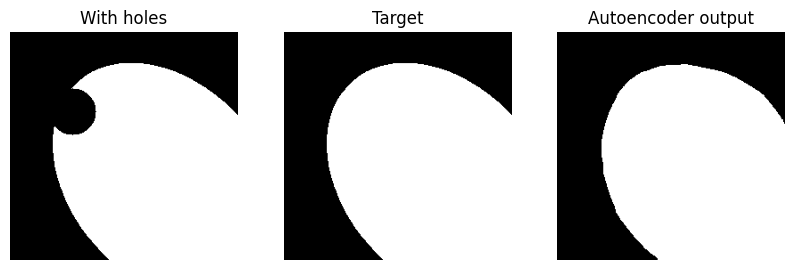

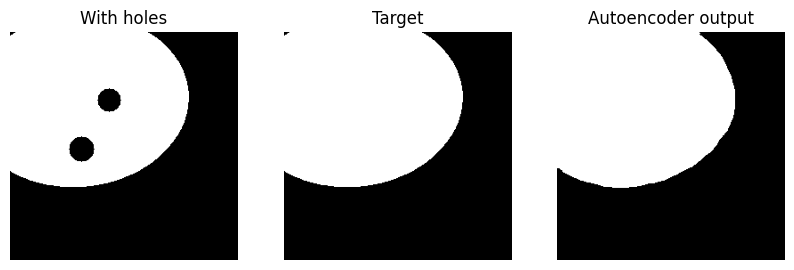

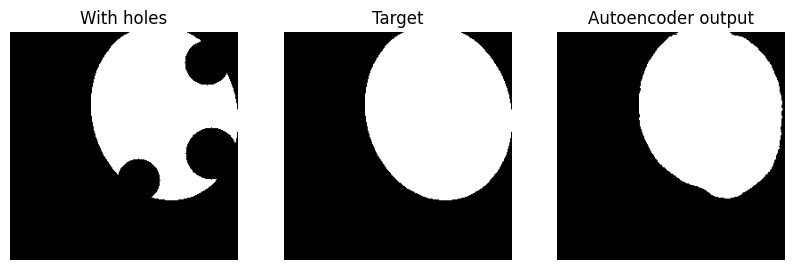

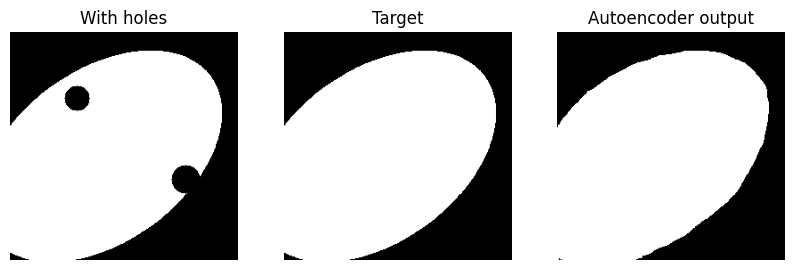

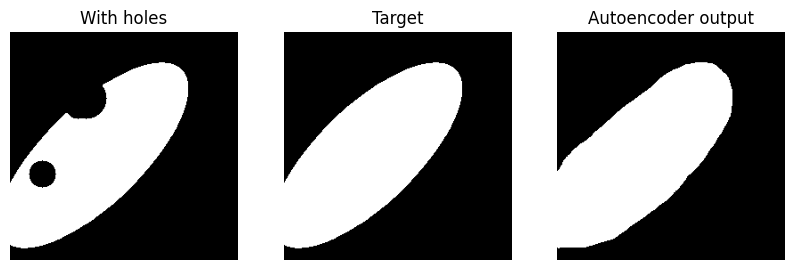

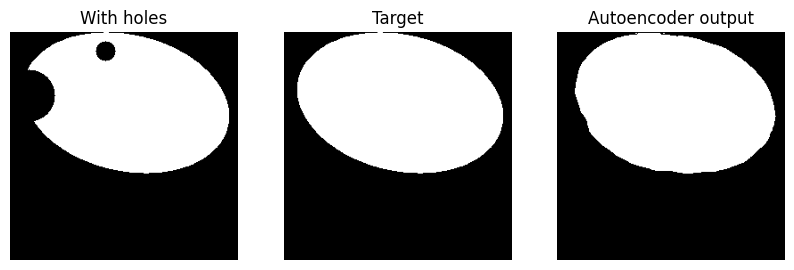

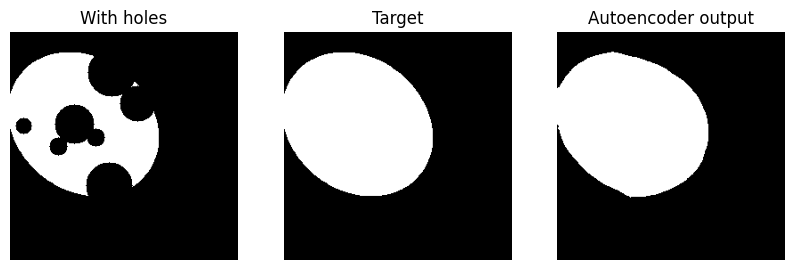

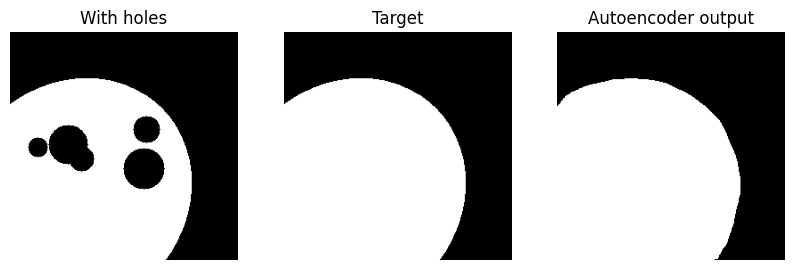

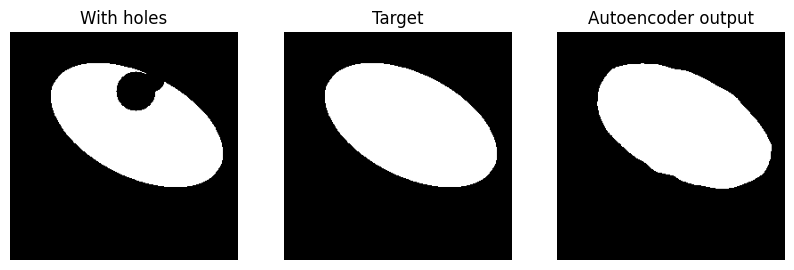

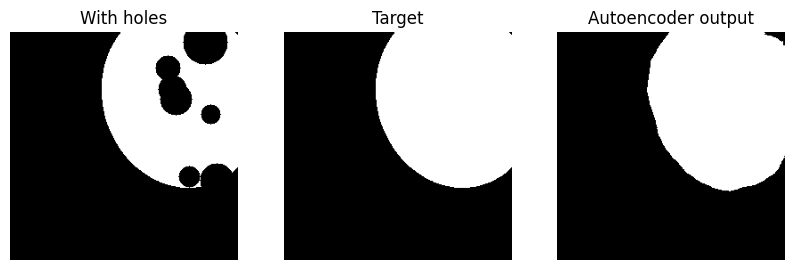

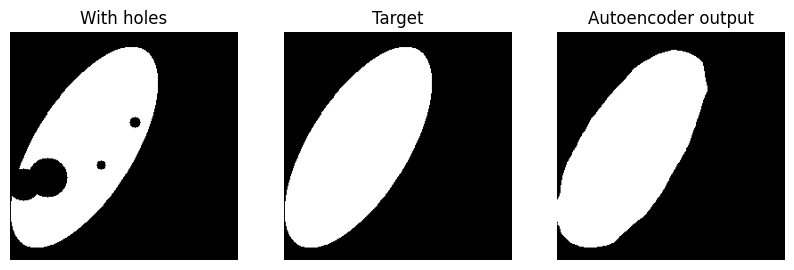

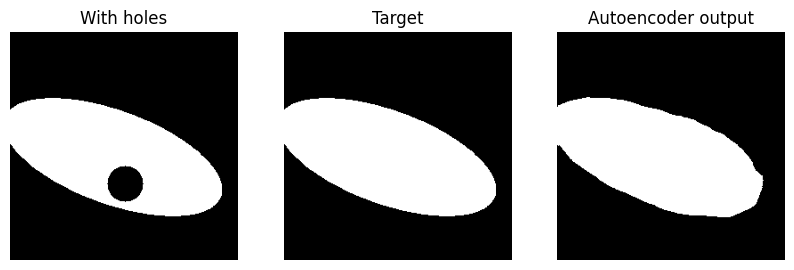

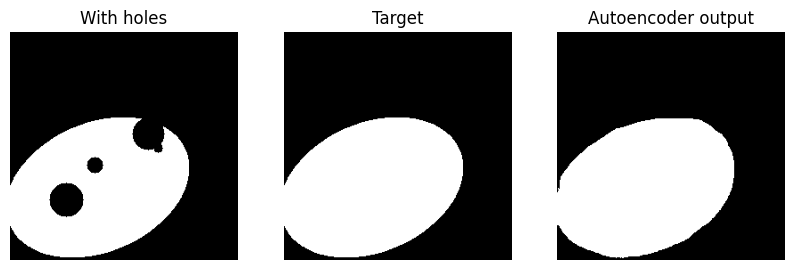

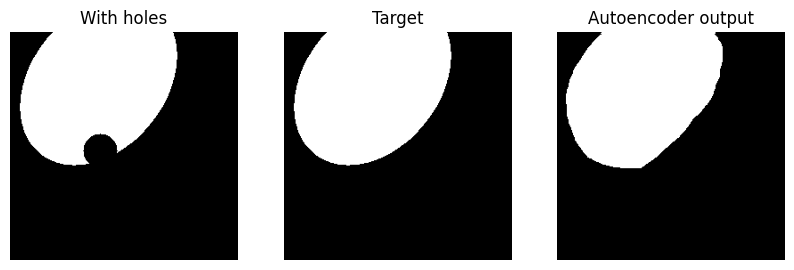

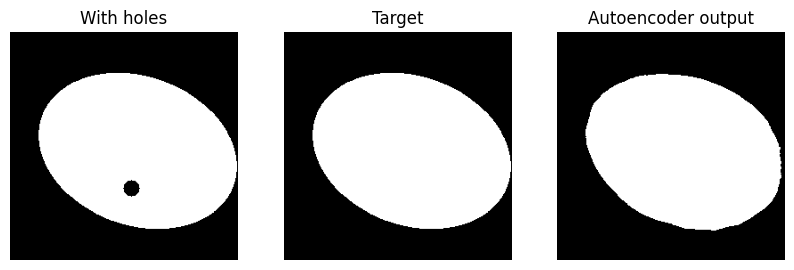

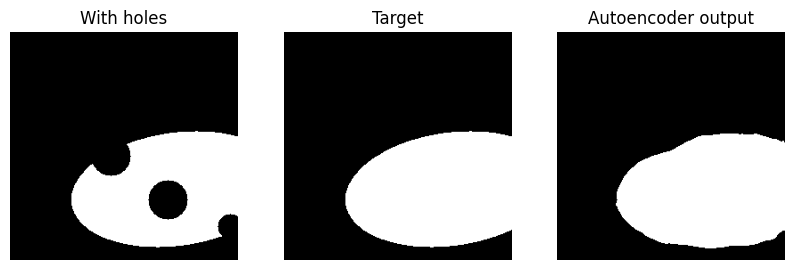

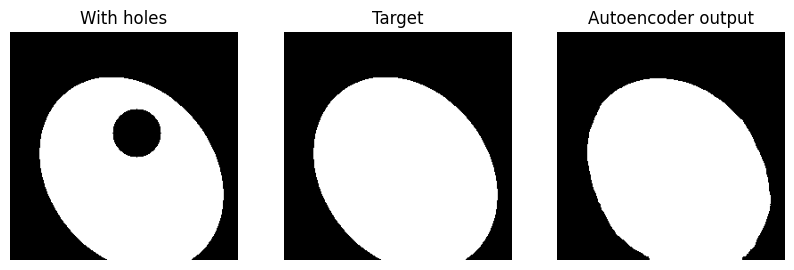

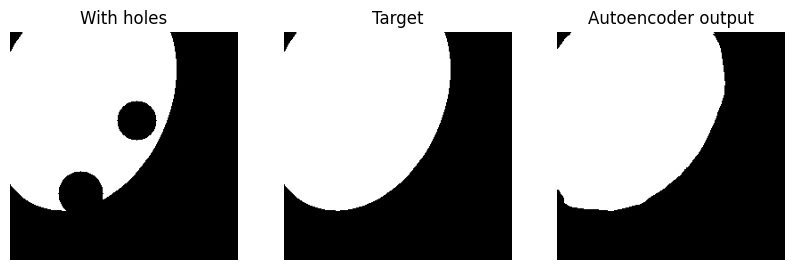

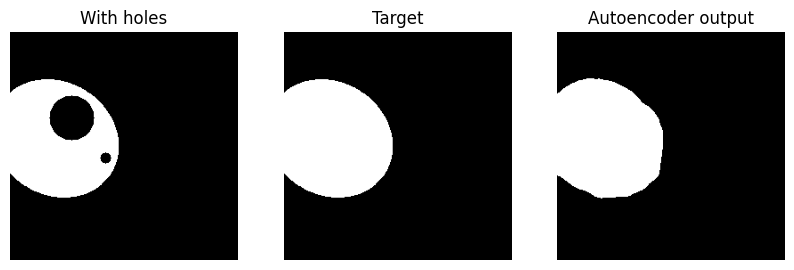

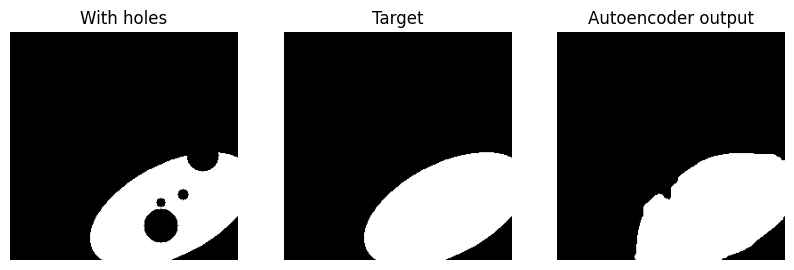

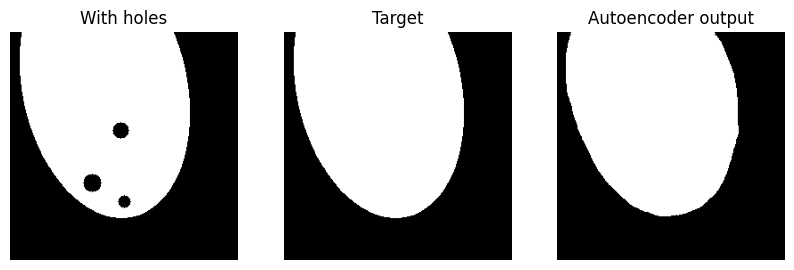

F1 Score: 0.9880525209682252


In [45]:
model_name: str = 'autoencoder_2024-11-25_0.9894749908447266'
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(f'results/{model_name}.pt', map_location=torch.device('cpu')))
autoencoder.to(device)

# Test
all_targets = np.array([])
all_outputs = np.array([])

autoencoder.eval()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(dataloaders['test']):
        if i > 20:
            break
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = autoencoder(inputs)

        outputs = (outputs > 0.5).float()
        visualize_ellipses(inputs[0].cpu().detach().numpy().squeeze(), targets[0].cpu().detach().numpy().squeeze(), outputs[0].cpu().detach().numpy().squeeze())
        all_targets = np.concatenate([all_targets, targets.cpu().detach().numpy().flatten()])
        all_outputs = np.concatenate([all_outputs, outputs.cpu().detach().numpy().flatten()])

f1 = f1_score(all_targets, all_outputs)
print(f'F1 Score: {f1}')